In [14]:
# imports and initializations
import os
import pickle
import numpy as np
import time
import matplotlib.pyplot as plt
import tarfile
import glob
import librosa
import itertools as itt
import torch
import transformers
from torch.nn import functional as F
import nltk
from nltk.corpus import stopwords
import scipy as sp

sent_Window=1 # windowing will happen by expanding sentences rather than words if 0 it's words rather than windows.
PCAV=1 # take pca of values or not
modelplus='-medium' # model type
#modelplus='' # model type
Twolayer=1
if Twolayer==1:
    TwolayerN='_2LYR'
else:
    TwolayerN=''
if sent_Window==1:
    sent_Window_N='WsentL'+TwolayerN
elif sent_Window==0:
    sent_Window_N='WwrdL'+TwolayerN
else:
    sent_Window_N='ent'
    

In [15]:
# import the GPT model to use:

import torch
from transformers import GPT2Tokenizer, GPT2LMHeadModel
import logging
logging.basicConfig(level=logging.INFO)
# Load pre-trained model tokenizer (vocabulary)
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')

model = GPT2LMHeadModel.from_pretrained('gpt2'+modelplus, output_hidden_states=True)

# Set the model in evaluation mode to deactivate the DropOut modules
# This is IMPORTANT to have reproducible results during evaluation!
model.eval()

Dictname='../linfo.pkl'
Lingname='../Data/after_aligner/hank.pickle'
#model = pickle.load(open(Dictname, 'rb'))

with open(Lingname, 'rb') as handle:
    datadict = pickle.load(handle)

In [16]:
# load the sentenced scripts:
add_sent='../Data/hank_scripts_proper/'
sent_names=glob.glob(add_sent+'*.txt')


namename=[idd[-10:-4] for idd in sent_names]
print(namename)

print(datadict['name'])

order=[namename.index(idd) for idd in datadict['name']]
print(order)

sent_names=[sent_names[idd] for idd in order]

#_, _, filenames = next(walk(add_sent))
stories=[]
for fn in sent_names:
    with open(fn) as f:
        stories.append(f.read().lower())

['stim08', 'stim09', 'stim19', 'stim18', 'stim01', 'stim15', 'stim14', 'stim16', 'stim02', 'stim03', 'stim17', 'stim13', 'stim07', 'stim06', 'stim12', 'stim04', 'stim10', 'stim11', 'stim05']
['stim08', 'stim09', 'stim19', 'stim18', 'stim16', 'stim02', 'stim03', 'stim17', 'stim01', 'stim15', 'stim14', 'stim04', 'stim10', 'stim11', 'stim05', 'stim13', 'stim07', 'stim06', 'stim12']
[0, 1, 2, 3, 7, 8, 9, 10, 4, 5, 6, 15, 16, 17, 18, 11, 12, 13, 14]


In [17]:
# concatenate all the stories in their correct order:
organized_order=[ datadict['name'].index('stim0'+str(idd)) if idd<10 else datadict['name'].index('stim'+str(idd)) for idd in range(1,len(datadict['name'])+1)]

print(organized_order)
org_storyN=[ datadict['name'][idd] for idd in organized_order]
print(org_storyN)
org_stories=[stories[idd] for idd in organized_order]
comp_story=' '.join(org_stories)
#print(comp_story)
org_str_wrds=[idd.split(' ') for idd in org_stories ]
org_str_len=[ len(idd) for idd in org_str_wrds]
str_wrds=[ j for i in org_str_wrds for j in i]
str_wrds2=[ ''.join(c for c in idd if c.isalpha()) if len(idd)>1 else idd for idd in str_wrds]
print(len(str_wrds), sum(org_str_len))


[8, 5, 6, 11, 14, 17, 16, 0, 1, 12, 13, 18, 15, 10, 9, 4, 7, 3, 2]
['stim01', 'stim02', 'stim03', 'stim04', 'stim05', 'stim06', 'stim07', 'stim08', 'stim09', 'stim10', 'stim11', 'stim12', 'stim13', 'stim14', 'stim15', 'stim16', 'stim17', 'stim18', 'stim19']
2682 2682


In [18]:
all_wrds=comp_story.split(' ')
all_wrds2=[ ''.join(c for c in idd if c.isalpha()) for idd in all_wrds]
#print(all_wrds2)
def unique(list1):
 
    # intilize a null list
    unique_list = []
     
    # traverse for all elements
    for x in list1:
        # check if exists in unique_list or not
        if x not in unique_list:
            unique_list.append(x)
    return unique_list
unique_wrds=unique(all_wrds2)
all_actual_wrds=[idd for idd in all_wrds2 if idd not in stopwords.words('english')]
print( 'number of actual words in the story:', len(all_actual_wrds),len(all_wrds2) )
#print('unique of all words:,unique(all_wrds2))
rep=[]
for wrd in unique_wrds:
    inst=[idd for idd,item in enumerate(all_wrds2) if item==wrd ]
    rep.append([len(inst), wrd])

rep_=[idd for idd in rep if idd[1] not in stopwords.words('english') ]
rep_Gthan4=[ idd for idd in rep_ if idd[0]>3]

print('number of words in the story that are repeated at least 4 times:', len(rep_Gthan4), rep_Gthan4)

number of actual words in the story: 1241 2682
number of words in the story that are repeated at least 4 times: 56 [[5, 'hank'], [9, 'dog'], [11, 'got'], [11, 'ranch'], [9, 'know'], [4, 'mean'], [6, 'took'], [5, 'job'], [6, 'head'], [5, 'security'], [15, 'could'], [4, 'tail'], [7, 'kind'], [6, 'nose'], [5, 'two'], [5, 'get'], [5, 'little'], [7, 'around'], [8, 'would'], [7, 'drover'], [4, 'anyway'], [4, 'made'], [10, 'right'], [4, 'night'], [10, 'heard'], [9, 'went'], [7, 'came'], [4, 'find'], [4, 'come'], [9, 'well'], [4, 'side'], [4, 'go'], [4, 'santiago'], [14, 'one'], [6, 'door'], [11, 'back'], [4, 'enough'], [4, 'kitchen'], [6, 'sally'], [6, 'may'], [6, 'table'], [8, 'sure'], [4, 'guy'], [4, 'years'], [5, 'never'], [5, 'dinner'], [4, 'take'], [4, 'ran'], [5, 'hear'], [4, 'think'], [4, 'house'], [4, 'tracks'], [4, 'say'], [4, 'country'], [6, 'cave'], [6, 'music']]


In [19]:
#print(str_wrds[0:50])
# make sentences, and address of sentence for each word
sent_counter=0
wrd_in_sent=[]
sentences=[]
in_sent_idd=[]
counter_in_sent_idd=0
sent_inst=[]
for item in str_wrds:
    
    wrd_in_sent.append(sent_counter)
    sent_inst.append(item)
    in_sent_idd.append(counter_in_sent_idd)
    counter_in_sent_idd=counter_in_sent_idd+1
    if '.' in item:
        counter_in_sent_idd=0
        sent_counter=sent_counter+1
        sentences.append(sent_inst)
        sent_inst=[]
#print(wrd_in_sent[0:50])
print('number of sentecnes: ',len(sentences))
idd=7
nw=0
#print(sentences[max(wrd_in_sent[idd]-nw,0):wrd_in_sent[idd]])
#print(sentences[wrd_in_sent[idd]][:in_sent_idd[idd]]+[str_wrds2[idd]])
WindowSent=sentences[max(wrd_in_sent[idd]-nw,0):wrd_in_sent[idd]]+[sentences[wrd_in_sent[idd]][:in_sent_idd[idd]]+[str_wrds2[idd]]]
WindowSent=[j for i in WindowSent for j in i]
print(' '.join(WindowSent))

number of sentecnes:  306
it is me again hank the cow dog


In [20]:
nw=20
if nw>=0:
        wrd_enc=[]
        for idd, item in enumerate(str_wrds2):
            WindowSent=sentences[max(wrd_in_sent[idd]-nw,0):wrd_in_sent[idd]]+[sentences[wrd_in_sent[idd]][:in_sent_idd[idd]]+[item]]
            WindowSent=[j for i in WindowSent for j in i]
            wrd_enc.append(tokenizer.encode(' '.join(WindowSent), add_special_tokens = True,
                                             truncation =True,
                                             add_prefix_space=True, return_tensors = "pt"))


In [21]:
# get the activation too all these words:


'''wrd_enc=[tokenizer.encode(' '.join(str_wrds[max(idd-nw,0):idd]+[item]), add_special_tokens = True,
                                         truncation =True,
                                         add_prefix_space=True, return_tensors = "pt") for idd, item in enumerate(str_wrds2)]
'''
output=[]
if sent_Window==1:
    TKN=[]
    Window=[-1, 0, 10] # -1 means the words on their own.
    #text2=[ ''.join(c for c in idd if c.isalpha()) for idd in text]
    for nw in Window:
        print('hi')
        if nw>=0:
            wrd_enc=[]
            for idd, item in enumerate(str_wrds2):
                WindowSent=sentences[max(wrd_in_sent[idd]-nw,0):wrd_in_sent[idd]]+[sentences[wrd_in_sent[idd]][:in_sent_idd[idd]]+[item]]
                WindowSent=[j for i in WindowSent for j in i]
                if len(WindowSent)>900:
                    print('for window:',nw,' length is ', len(WindowSent) )
                    WindowSent=WindowSent[-900:]
                text_inp=tokenizer.encode(' '.join(WindowSent), add_special_tokens = True,
                                                 truncation =True,
                                                 add_prefix_space=True, return_tensors = "pt")
                if len(text_inp[0])>=1024:
                    print(" maximum input length violated")

                wrd_enc.append(text_inp)
        else:
            wrd_enc=[tokenizer.encode(' '.join([item]), add_special_tokens = True,
                                             truncation =True,
                                             add_prefix_space=True, return_tensors = "pt") for idd, item in enumerate(str_wrds2)]

        outputs=[]
        with torch.no_grad():
            for idd,item in enumerate(wrd_enc):
                if Twolayer==1:
                    outputs.append( [model(item)[2][0][:,-1,:].cpu().detach().numpy(),model(item)[2][-1][:,-1,:].cpu().detach().numpy() ])
                else:
                    outputs.append( [igg[:,-1,:].cpu().detach().numpy() for igg in model(item)[2]])
            #model(item)[2][0][:,-1,:],model(item)[2][12][:,-1,:]
        output.append(outputs)
        TKN.append(wrd_enc)
        print('bye')
elif sent_Window==0:
    TKN=[]
    Window=[0, 2, 5,10,20, 50,100,200, 500,900] # -1 means the words on their own.
    #text2=[ ''.join(c for c in idd if c.isalpha()) for idd in text]
    for nw in Window:
        print('hi')
        if nw>=0:
            wrd_enc=[]
            for idd, item in enumerate(str_wrds2):
                text_inp=tokenizer.encode(' '.join(str_wrds[max(idd-nw,0):idd]+[item]), add_special_tokens = True,
                                         truncation =True,
                                         add_prefix_space=True, return_tensors = "pt")
                if len(text_inp[0])>=1024:
                    print(" maximum input length violated")

                wrd_enc.append(text_inp)
        outputs=[]
        with torch.no_grad():
            for idd,item in enumerate(wrd_enc):
                outputs.append( [igg[:,-1,:].cpu().detach().numpy() for igg in model(item)[2]])
            #model(item)[2][0][:,-1,:],model(item)[2][12][:,-1,:]
        output.append(outputs)
        TKN.append(wrd_enc)
        print('bye')
else:
    Window=[]


'''text='hello.\n'
input = tokenizer.encode(text, add_special_tokens = True,
                                 truncation =True,
                     add_prefix_space=True,
                               return_tensors = "pt")
with torch.no_grad():
    output = model(input)
#a=tokenizer.decode(input[0]).split(' ')
#new_words=[idd[2][1:-1].lower() for idd in datadict['words'][i] if idd[2][1:-1]!='sp']
#a=[ ''.join(c for c in idd if c.isalpha()) for idd in a]
a=input[0].cpu().detach().numpy()
print(input, a)'''

hi
bye
hi
bye
hi
bye


'text=\'hello.\n\'\ninput = tokenizer.encode(text, add_special_tokens = True,\n                                 truncation =True,\n                     add_prefix_space=True,\n                               return_tensors = "pt")\nwith torch.no_grad():\n    output = model(input)\n#a=tokenizer.decode(input[0]).split(\' \')\n#new_words=[idd[2][1:-1].lower() for idd in datadict[\'words\'][i] if idd[2][1:-1]!=\'sp\']\n#a=[ \'\'.join(c for c in idd if c.isalpha()) for idd in a]\na=input[0].cpu().detach().numpy()\nprint(input, a)'

In [28]:
print(sent_Window_N)
print(Window)

WsentL_2LYR
[-1, 0, 10, -2]


In [23]:
#print(len(output[0])) # [output]= nWindows*nWrds*2(0+last)*1*nNeurons
# adding the whole story representationto output
#
output_all2_start=0
for portion in range(0,len(str_wrds2),800):
    text=' '.join(str_wrds2[portion:portion+800])
    input = tokenizer.encode(text, add_special_tokens = True,
                                         truncation =True,
                             add_prefix_space=True,
                                       return_tensors = "pt")
    print(len(input[0]))
    with torch.no_grad():

        output_all = model(input)
        if output_all2_start==0:
            LAyers=[0, -1]#range(len(output_all[2]))
            output_all2=[output_all[2][idd].cpu().detach().numpy() for idd in LAyers ] #layer, batch, nToken, neuron
            a=input[0].cpu().detach().numpy()
            output_all2_start=output_all2_start+1
        else:
            output_all2=[np.concatenate( ( output_all2[idd],output_all[2][idd].cpu().detach().numpy()), axis=1) for idd in LAyers ]
            a=np.concatenate( (a,input[0].cpu().detach().numpy()), axis=0)
        ##a=tokenizer.decode(input[0]).split(' ')
        #new_words=[idd[2][1:-1].lower() for idd in datadict['words'][i] if idd[2][1:-1]!='sp']
        ##a=[ ''.join(c for c in idd if c.isalpha()) for idd in a]

wrd_enc=[tokenizer.encode(item, add_special_tokens = True,
                                 truncation =True,add_prefix_space=True,
                               return_tensors = "pt")[0].cpu().detach().numpy() for item in str_wrds2]
wrd_enc=[ item[-1] for item in wrd_enc ]
counter=0
tknIdx=[]
a=[j for j in a]
counter=0
tknIdx=[]
act_all=[]
for wrd in wrd_enc:
    if wrd in a[counter:]:
        idd=a[counter:].index(wrd)
        tknIdx.append(idd+counter)
        act_all.append([item_layer[:,idd+counter,:] for item_layer in output_all2])
        counter=counter+idd+1
    else:
        print('wrd not in tokenizer output')
output.append(act_all)
Window.append(-2)


839
838
827
296


In [29]:
print(len(output_all[2]))

25


In [30]:
# [output]= nWindows*nWrds*2(layer 0 and last)*1*nNeurons
# making output numpy
nNeurons=(output[0][0][0]).shape[1]
print(' number of neurons:',nNeurons )
nLYR=len(output[0][0])
print(' number of layers:',nLYR )
activation=np.zeros((len(Window),len(str_wrds2), nLYR, nNeurons ))
for wndID,wnd in enumerate(Window):
    for wrdID in range(len(str_wrds2)):
        for layer in range(nLYR):
            activation[wndID,wrdID,layer, :] =output[wndID][wrdID][layer]#.cpu().detach().numpy()

 number of neurons: 1024
 number of layers: 2


In [31]:
print(activation.shape)
#print(len(sentences),name)
#
from scipy.io import savemat
all_wrds_dict={'actv':[]}
all_wrds_dict['actv']=activation
all_wrds_dict['nonStopWrds']=np.asarray([1 if idd not in stopwords.words('english') else 0 for idd in str_wrds2])
all_wrds_dict['all_wrds']=str_wrds2
all_wrds_dict['window']=Window
all_wrds_dict['sents']=sentences
Savename='../Data/after_aligner/hankGPT2'+modelplus+'FN'+sent_Window_N+'_allWords_beforeDR'+'.mat'
# save the files to .mat 
#print(all_wrds_dict)
savemat(Savename, all_wrds_dict)

(4, 2682, 2, 1024)


In [32]:
# looking at the representations of sentences and words throughout the network:
# firs we look at the tsnes through the layers:
'''wnd=0
from sklearn.manifold import TSNE
import pandas as pd
from colour import Color
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D

red = Color("red")
colors = list(red.range_to(Color("green"),len(sentences)))
%matplotlib notebook
fig = plt.figure(figsize=(5,5))

    
for layr in range(activation.shape[2]):
    X = np.squeeze(activation[:,:,layr,:])
    tsne=TSNE(n_components=3)
    Xn = tsne.fit_transform(X)
    #axs[SNR, layr].axes(projection='3d')
    ax = fig.add_subplot(5,3 , layr+1, projection='3d')
    ax.plot3D(Red_act_ref[:,0], Red_act_ref[:,1], Red_act_ref[:,2], 'gray')
    ax.text(Red_act_ref[-1,0], Red_act_ref[-1,1], Red_act_ref[-1,2], "end_ref", color='red')
    ax.plot3D(Red_act_test[:,0], Red_act_test[:,1], Red_act_test[:,2], 'gray')
    ax.text(Red_act_test[-1,0], Red_act_test[-1,1], Red_act_test[-1,2], "end_test", color='red')
    
    
layr=12
X = np.squeeze(activation[:,:,layr,:])
tsne=TSNE(n_components=3)
Xn = tsne.fit_transform(X)
ax = fig.add_subplot(5,3 , layr+1)
ax = Axes3D(fig)
#ax.scatter(Xn[:,0].T, Xn[:,1].T,marker='o')
df = pd.DataFrame(dict(x=Xn[:,0].T, y=Xn[:,1].T, z=Xn[:,2].T, label=wrd_in_sent))

groups = df.groupby('label')
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
for name, group in groups:
    #print(name)
    ax.scatter(group.x, group.y,group.z,s=3)
for wrdID,wrd in enumerate(str_wrds):
    ax.text(Xn[wrdID,0],Xn[wrdID,1],Xn[wrdID,2],  '%s' % (wrd), size=3, zorder=1, color='k')
'''
        

'wnd=0\nfrom sklearn.manifold import TSNE\nimport pandas as pd\nfrom colour import Color\nimport matplotlib as mpl\nfrom mpl_toolkits.mplot3d import Axes3D\n\nred = Color("red")\ncolors = list(red.range_to(Color("green"),len(sentences)))\n%matplotlib notebook\nfig = plt.figure(figsize=(5,5))\n\n    \nfor layr in range(activation.shape[2]):\n    X = np.squeeze(activation[:,:,layr,:])\n    tsne=TSNE(n_components=3)\n    Xn = tsne.fit_transform(X)\n    #axs[SNR, layr].axes(projection=\'3d\')\n    ax = fig.add_subplot(5,3 , layr+1, projection=\'3d\')\n    ax.plot3D(Red_act_ref[:,0], Red_act_ref[:,1], Red_act_ref[:,2], \'gray\')\n    ax.text(Red_act_ref[-1,0], Red_act_ref[-1,1], Red_act_ref[-1,2], "end_ref", color=\'red\')\n    ax.plot3D(Red_act_test[:,0], Red_act_test[:,1], Red_act_test[:,2], \'gray\')\n    ax.text(Red_act_test[-1,0], Red_act_test[-1,1], Red_act_test[-1,2], "end_test", color=\'red\')\n    \n    \nlayr=12\nX = np.squeeze(activation[:,:,layr,:])\ntsne=TSNE(n_components=3)\nX

In [33]:
## dimention reduction methods:
DimRs=['PCA_mr','PCA_n', 'PCA','MDS', 'LLE', 'PPA+PCA' ]
# these methods are gonna be added on the Window dimension since we are using only one window dim. 


In [35]:
print((activation.shape)) # wind, words, layer, neurons. 
#take the PCA
# first we concatinate all the words and windows for the two layers:
Act=activation.reshape((-1,nLYR,nNeurons))
print(Act.shape)

# find the norms of eacl neauron at each layer:
Norm_act=np.linalg.norm(Act,axis=0)
print(Norm_act[None,:,:].shape)
# normalize Act and activation:
Act_n=Act/Norm_act[None,:,:]
activation_n=activation/Norm_act[None,None,:,:]
tmp=activation_n.reshape((-1,nLYR,nNeurons))
print(np.linalg.norm(tmp,axis=0))



## z-score activation:
Act_m=np.mean(Act,axis=0)
Act_std=np.std(Act,axis=0)

activation_zs=(activation-Act_m[None,None,:,:])/Act_std[None,None,:,:]
#activation_zs=sp.stats.zscore(activation,axis=1) # WARNING: it is assumed that the first dimmension is 1
print((activation_zs.shape))


## mean removed:
activation_mr=activation-Act_m[None,None,:,:] # WARNING: it is assumed that the first dimmension is 1
print('activation_mr',activation_mr.shape)


(4, 2682, 2, 1024)
(10728, 2, 1024)
(1, 2, 1024)
[[1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]]
(4, 2682, 2, 1024)
activation_mr (4, 2682, 2, 1024)


In [30]:

activation_mr=activation_mr[-1,:,:,:]
activation_mr=activation_mr[-1,:,:,:]

print('Window length must be 1. it is:', len(Window))

Window length must be 1. it is: 1


 initial ncmp for PPA is:  1024
[312, 1]
activation_PPA shape is  (4, 2682, 2, 1024)
(4, 2682, 2, 1024)


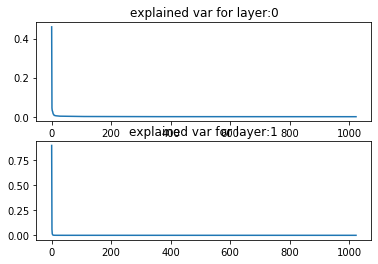

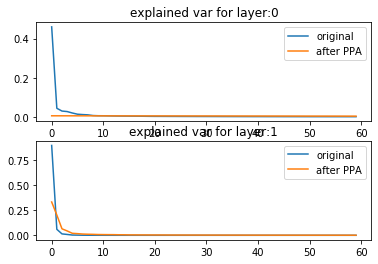

In [43]:
# we first check how much of the zscored data's variance is explaind by each PC:
# then apply PPA and zscore
ncmp=nNeurons
print(' initial ncmp for PPA is: ', ncmp)
from sklearn.decomposition import PCA
PCAs=[]
fig, axs = plt.subplots(2, 1)
Threshold=0.95
D=[]

for layer in range(nLYR):
    pca=PCA(n_components=ncmp)
    pca.fit(np.squeeze(activation_mr.reshape((-1,nLYR,nNeurons))[:,layer, :]))
    PCAs.append(pca)
    cumSumVar=pca.explained_variance_ratio_.cumsum()
    thresholed=[idd for idd,item in enumerate(cumSumVar) if item>Threshold]
    D.append(thresholed[0])
    axs[layer].plot(pca.explained_variance_ratio_)
    axs[layer].set_title('explained var for layer:'+str(layer))
print(D)    
    
# apply PPA:
activation_PPA=np.zeros((len(Window),len(str_wrds2), nLYR, ncmp ))
#[PCAs[0].components_]= ncmp*ndim(original)
for wnd in range(len(Window)):
    for layer in range(nLYR):
        activation_PPA[wnd,:,layer, :]=np.squeeze(activation_mr[wnd,:,layer, :])-PCAs[layer].transform(np.squeeze(activation_mr[wnd,:,layer, :]))[:,:D[layer]+1]@ PCAs[layer].components_[:D[layer]+1,:]

print('activation_PPA shape is ', activation_PPA.shape)

# do the PCA to see how the variance compares:
PCAsofPPA=[]
fig, axs = plt.subplots(2, 1)
ncmp=60
for layer in range(nLYR):
    pca=PCA(n_components=ncmp)
    pca.fit(np.squeeze(activation_PPA.reshape((-1,nLYR,nNeurons))[:,layer, :]))
    PCAsofPPA.append(pca)
    axs[layer].plot(PCAs[layer].explained_variance_ratio_[:ncmp])
    axs[layer].plot(pca.explained_variance_ratio_)
    axs[layer].set_title('explained var for layer:'+str(layer))
    axs[layer].legend(['original', 'after PPA'])
    
# zscore PPA:
Act_PPA=activation_PPA.reshape((-1,nLYR,nNeurons))
Act_PPA_m=np.mean(Act,axis=0)
Act_PPA_std=np.std(Act,axis=0)
activation_PPA_zs=(activation_PPA-Act_PPA_m[None,None,:,:])/Act_PPA_std[None,None,:,:]
print((activation_PPA_zs.shape))

In [45]:
## apply the dimension reductions:
ncmp=60
pcaName='DRs'
#DimRs=['PCA_mr','PCA_n', 'PCA','MDS', 'LLE', 'PPA+PCA' ]
activation_r=np.zeros((len(DimRs),len(Window),len(str_wrds2), nLYR, ncmp ))
for idDR, DR_name in enumerate(DimRs):
    if DR_name=='PCA_mr':
        from sklearn.decomposition import PCA
        PCAs=[]
        for layer in range(nLYR):
            pca=PCA(n_components=ncmp)
            pca.fit(np.squeeze(activation_mr.reshape((-1,nLYR,nNeurons))[:,layer, :]))
            PCAs.append(pca)
        
        print('applying PCA_mr:')
        for wnd in range(len(Window)):
            for layer in range(nLYR):
                    activation_r[idDR,wnd,:,layer, :]=PCAs[layer].transform(np.squeeze(activation_mr[wnd,:,layer, :]))    
    if DR_name=='PCA_n':
        from sklearn.decomposition import PCA
        # now we transform the activation matrix:
        print('applying PCA_n:')
        PCAs=[]
        for layer in range(nLYR):
            pca=PCA(n_components=ncmp)
            pca.fit(np.squeeze(activation_n.reshape((-1,nLYR,nNeurons))[:,layer, :]))
            PCAs.append(pca)

        for wnd in range(len(Window)):
            for layer in range(nLYR):
                    activation_r[idDR,wnd,:,layer, :]=PCAs[layer].transform(np.squeeze(activation_n[wnd,:,layer, :]))
    if DR_name=='PCA':
        from sklearn.decomposition import PCA
    
        print('applying PCA:')
        PCAs=[]
        for layer in range(nLYR):
            pca=PCA(n_components=ncmp)
            pca.fit(np.squeeze(activation_zs.reshape((-1,nLYR,nNeurons))[:,layer, :]))
            PCAs.append(pca)

        for wnd in range(len(Window)):
            for layer in range(nLYR):
                    activation_r[idDR,wnd,:,layer, :]=PCAs[layer].transform(np.squeeze(activation_zs[wnd,:,layer, :]))
    if DR_name=='MDS':
        from sklearn.metrics.pairwise import cosine_distances
        from sklearn.manifold import MDS
        # now we transform the activation matrix:
        print('applying MDS:')
        for wnd in range(len(Window)):
            for layer in range(nLYR):
                pca=MDS(n_components=ncmp,dissimilarity='precomputed')
                activation_r[idDR,wnd,:,layer, :]=pca.fit_transform(cosine_distances(np.squeeze(activation[wnd,:,layer, :])))
    if DR_name=='LLE':
        from sklearn.manifold import LocallyLinearEmbedding
        # now we transform the activation matrix:
        print('applying LLE:')
        PCAs=[]
        for layer in range(nLYR):
            pca=LocallyLinearEmbedding(n_components=ncmp)
            pca.fit(np.squeeze(activation.reshape((-1,nLYR,nNeurons))[:,layer, :]))
            PCAs.append(pca)

        for wnd in range(len(Window)):
            for layer in range(nLYR):
                    activation_r[idDR,wnd,:,layer, :]=PCAs[layer].transform(np.squeeze(activation[wnd,:,layer, :]))
    if DR_name=='PPA+PCA':
        
        from sklearn.decomposition import PCA
        # now we transform the activation matrix:
        print('applying PPA+PCA:')
        PCAs=[]
        for layer in range(nLYR):
            pca=PCA(n_components=ncmp)
            pca.fit(np.squeeze(activation_PPA.reshape((-1,nLYR,nNeurons))[:,layer, :]))
            PCAs.append(pca)

        for wnd in range(len(Window)):
            for layer in range(nLYR):
                    activation_r[idDR,wnd,:,layer, :]=PCAs[layer].transform(np.squeeze(activation_PPA[wnd,:,layer, :]))


        
    

applying PCA_mr:
applying PCA_n:
applying PCA:
applying MDS:
applying LLE:
applying PPA+PCA:


In [46]:
'''# Applying PCA on each layer and keeping 60 PCs:
if PCAV==1:
    ncmp=60
    pcaName='Norm_pca'
    import numpy as np
    from sklearn.decomposition import PCA
    PCAs=[]
    activation_r=np.zeros((len(Window),len(str_wrds2), nLYR, ncmp ))
    for layer in range(nLYR):
        pca=PCA(n_components=ncmp)
        pca.fit(np.squeeze(Act_n[:,layer, :]))
        PCAs.append(pca)
    # now we transform the activation matrix:
    print('applying PCA:')
    for wndID,wnd in enumerate(Window):
        for wrdID in range(len(str_wrds2)):
            for layer in range(nLYR):
                activation_r[wndID,wrdID,layer, :]=PCAs[layer].transform(np.squeeze(activation_n[wndID,wrdID,layer, :])[np.newaxis,:])
else:
    pcaName=''
    activation_r=np.zeros((len(Window),len(str_wrds2), nLYR, ncmp ))
    
    # now we transform the activation matrix:
    print('not applying PCA:')
    for wndID,wnd in enumerate(Window):
        for wrdID in range(len(str_wrds2)):
            for layer in range(nLYR):
                activation_r[wndID,wrdID,layer, :]=np.squeeze(activation[wndID,wrdID,layer, :])[np.newaxis,:]
'''

"# Applying PCA on each layer and keeping 60 PCs:\nif PCAV==1:\n    ncmp=60\n    pcaName='Norm_pca'\n    import numpy as np\n    from sklearn.decomposition import PCA\n    PCAs=[]\n    activation_r=np.zeros((len(Window),len(str_wrds2), nLYR, ncmp ))\n    for layer in range(nLYR):\n        pca=PCA(n_components=ncmp)\n        pca.fit(np.squeeze(Act_n[:,layer, :]))\n        PCAs.append(pca)\n    # now we transform the activation matrix:\n    print('applying PCA:')\n    for wndID,wnd in enumerate(Window):\n        for wrdID in range(len(str_wrds2)):\n            for layer in range(nLYR):\n                activation_r[wndID,wrdID,layer, :]=PCAs[layer].transform(np.squeeze(activation_n[wndID,wrdID,layer, :])[np.newaxis,:])\nelse:\n    pcaName=''\n    activation_r=np.zeros((len(Window),len(str_wrds2), nLYR, ncmp ))\n    \n    # now we transform the activation matrix:\n    print('not applying PCA:')\n    for wndID,wnd in enumerate(Window):\n        for wrdID in range(len(str_wrds2)):\n        

In [47]:
print(activation_r.shape)
print(organized_order)

(6, 4, 2682, 2, 60)
[8, 5, 6, 11, 14, 17, 16, 0, 1, 12, 13, 18, 15, 10, 9, 4, 7, 3, 2]


In [48]:
# expanding the word context gradually at the last layer:
TKN=[]
start_wrds=[]
ACT=[]
for i in range(len(stories)):
    # find the start and end address in the concatinated story: str_wrds2
    
    new_words=[idd[2][1:-1].lower() for idd in datadict['words'][i] if idd[2][1:-1]!='sp']
    # what story does it correspond to?
    idx=organized_order.index(i)
    idx_start=sum(org_str_len[:idx])
    idx_end=sum(org_str_len[:idx+1])
    tknIdx=[]
    counter=0
    non_stopwrds=[1 if idd not in stopwords.words('english') else 0 for idd in new_words]
    for wrd in new_words:
        if wrd in str_wrds2[idx_start+counter:idx_end]:
            idd=str_wrds2[idx_start+counter:idx_end].index(wrd)
            tknIdx.append(idx_start+idd+counter)
            counter=counter+idd+1
        else:
            print('wrd not in tokenizer output', wrd)
    TKN.append(tknIdx)
    
    
    new_phonemes=[idd for idd in datadict['phonemes'][i] if idd[2]!='sp']
    new_words=[idd for idd in datadict['words'][i] if idd[2][1:-1]!='sp']
    datadict['phonemes'][i]=new_phonemes
    datadict['words'][i]=new_words
    ACT.append(activation_r[:,:,tknIdx,:, :])
    start_wrds.append(np.array(non_stopwrds)[np.newaxis,:])


In [49]:
print(start_wrds[0].shape)

(1, 191)


In [51]:
tokenL=[ idd.shape[2] for idd in ACT]
maxL=max(tokenL)
print(tokenL)
print(maxL)
## pad zeros
ACT=[ np.concatenate( (idd, np.zeros((idd.shape[0],idd.shape[1] ,maxL- idd.shape[2], idd.shape[3], idd.shape[4]))),axis=2) for idd in ACT]
start_wrds=[ np.concatenate( (idd, np.zeros((idd.shape[0],maxL- idd.shape[1]))),axis=1) for idd in start_wrds]

print(ACT[0].shape,start_wrds[0].shape)

[191, 170, 2, 68, 94, 154, 192, 62, 167, 86, 88, 176, 139, 151, 198, 113, 226, 199, 190]
226
(6, 4, 226, 2, 60) (1, 226)


In [52]:
activations=np.asarray(ACT)
start_words=np.asarray(start_wrds)
print(activations.shape,start_words.shape )

(19, 6, 4, 226, 2, 60) (19, 1, 226)


In [54]:
'''#print(stopwords.words('english'))
i=5
print(len(datadict['words'][i]), datadict['actv'][i].shape)
new_words=[idd[2][1:-1].lower() for idd in datadict['words'][i] if idd[2][1:-1]!='sp']
print(datadict['nonStopWrds'][i], len(datadict['nonStopWrds'][i]))

wrdsStop=[item for idd,item in enumerate(new_words) if datadict['nonStopWrds'][i][idd]==1]
print(wrdsStop)
print(Window)'''

from scipy.io import savemat
datadict['actv']=activations
datadict['nonStopWrds']=start_words
datadict['window']=Window
datadict['DRmethods']=DimRs
Savename='../Data/after_aligner/hankGPT2'+modelplus+'FN'+sent_Window_N+'_'+pcaName+'.mat'
# save the files to .mat 

savemat(Savename, datadict)

In [55]:
#np.asarray(datadict['nonStopWrds'])

print(Savename)

../Data/after_aligner/hankGPT2-mediumFNWsentL_2LYR_DRs.mat


In [56]:
print(Act.shape)

(10728, 2, 1024)


In [42]:
print(activations[0,4,:,1,:])
print(cosine_distances(np.squeeze(activation_zs[:,:,layer, :])))

[[-0.00105901 -0.01824948 -0.00075396 ...  0.03721732  0.00622385
  -0.11510081]
 [ 0.0023745  -0.01888404 -0.03326497 ... -0.00375302 -0.00503765
  -0.00268101]
 [ 0.00026623 -0.01780795  0.00930467 ...  0.00940461 -0.00479928
  -0.00301544]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
[[0.         0.71377863 0.79773984 ... 0.90977645 0.97630911 0.94704813]
 [0.71377863 0.         0.55877124 ... 0.84535271 0.96201411 0.91030335]
 [0.79773984 0.55877124 0.         ... 0.88055337 0.99496197 0.98136305]
 ...
 [0.90977645 0.84535271 0.88055337 ... 0.         0.68462389 0.73704546]
 [0.97630911 0.96201411 0.99496197 ... 0.68462389 0.         0.72674615]
 [0.94704813 0.91030335 0.98136305 ... 0.73704546 0.72674615 0.        ]]


In [43]:
a=cosine_distances(np.squeeze(activation_zs[:,:,layer, :]))
from sklearn.manifold import MDS
# now we transform the activation matrix:
print('applying MDS:')
layer=1
pca=MDS(n_components=ncmp,dissimilarity='precomputed')
b=pca.fit_transform(a)
print(b)


applying MDS:
[[ 0.0187579  -0.13765596 -0.12693204 ... -0.05117913 -0.01593317
   0.04371622]
 [ 0.00755739  0.00952576 -0.06225134 ...  0.02430559 -0.05198937
  -0.03936052]
 [ 0.04149736 -0.10022929 -0.11822294 ... -0.12396124  0.08878997
  -0.08924105]
 ...
 [ 0.03942662 -0.16168656 -0.11476682 ... -0.04855714 -0.04542532
  -0.07711456]
 [ 0.13070307 -0.04437114 -0.14151299 ...  0.00726114  0.03311524
  -0.15823054]
 [ 0.12124917  0.06571801 -0.02855442 ...  0.01663156 -0.04400266
  -0.0293802 ]]


In [83]:
print(b.shape)

(2682, 60)
